In [13]:
import copy
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import matplotlib.lines as lines

from random import randrange
from scipy import stats

In [2]:
def load_csv(path_to_data):
    with open(path_to_data) as f:
        data = []

        col_names = None

        for row in csv.reader(f):
            if not col_names:
                col_names = row
                col_names[0] = 'age'
            else:
                data.append([float(i) for i in row])

    return col_names, data

def prepare_data(data):
    """
    Use z-score of input feature values
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
    https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)
    """
    feature_vectors = []
    output_classes = []
    
    for entry in data:
        feature_vectors.append(entry[0:-1])
        output_classes.append([entry[-1]])
        
    feature_vectors = np.array(feature_vectors).astype(np.float64)
    feature_vectors = np.apply_along_axis(stats.zscore, 0, feature_vectors)
        
    return feature_vectors, np.array(output_classes), np.hstack((feature_vectors, np.array(output_classes)))

def split_data(all_data, train_perc=0.85, seed=0):
    np.random.seed(seed)
    num_train = math.floor(train_perc * len(all_data))
    
    use_data = copy.deepcopy(all_data)
    
    np.random.shuffle(use_data)
    
    training = []
    while len(training) < num_train:
        sample, use_data = use_data[-1], use_data[:-1]
        
        training.append(sample)
    testing = use_data
    
    training_xs = []
    training_ys = []
    for ind in range(len(training)):
        training_xs.append(training[ind][0:-1])
        training_ys.append(training[ind][-1])
    
    testing_xs = []
    testing_ys = []
    for ind in range(len(testing)):
        testing_xs.append(testing[ind][0:-1])
        testing_ys.append(testing[ind][-1])
        
    training_ys = np.expand_dims(training_ys, 1)
    testing_ys = np.expand_dims(testing_ys, 1)
        
    return ((np.array(training_xs), np.array(training_ys).astype(int)), (np.array(testing_xs), np.array(testing_ys).astype(int)))

def split_into_k((xs, ys), k):
    xs_copy = list(copy.deepcopy(xs))
    ys_copy = list(copy.deepcopy(ys))
    
    xs_ys_pairs = []

    fold_len = int(len(xs) / k)
    
    for _ in range(k):
        this_fold_xs = []
        this_fold_ys = []
        
        while len(this_fold_xs) < fold_len:
            ind = randrange(len(xs_copy))
            this_fold_xs.append(xs_copy.pop(ind))
            this_fold_ys.append(ys_copy.pop(ind))
        
        xs_ys_pairs.append((np.array(this_fold_xs), np.array(this_fold_ys)))
        
    return xs_ys_pairs

In [3]:
def data_by_class(data):
    by_class = {}
    for sample in data:
        class_val = sample[-1]
        if not by_class.get(class_val):
            by_class[class_val] = []
        
        by_class[class_val].append(sample[0:-1])
        
    return {k: np.array(v) for k, v in by_class.items()}

def _class_stats_helper(feature_vectors):
    statistics = []
    
    for col_ind in range(feature_vectors.shape[1]):
        col_vals = feature_vectors[:, col_ind]
        mean = np.mean(col_vals)
        stddev = np.std(col_vals)
        num_vals = len(col_vals)
        
        statistics.append((mean, stddev, num_vals))
        
    return statistics

def class_stats(samples):
    by_class = data_by_class(samples)
    stats = {}
    
    for class_val, class_samples in by_class.items():
        stats[class_val] = _class_stats_helper(class_samples)
        
    return stats

def calc_gaussian_prob(x, mean, stddev):
    e = np.exp(-((x - mean) ** 2 / (2 * stddev ** 2)))
    return (1 / (np.sqrt(2 * np.pi) * stddev)) * e

def _calc_class_helper(statistics, feature_vector):
    total_samples = sum([statistics[class_val][0][2] for class_val in statistics])
    class_probs = {}
    
    for class_val, class_stats in statistics.items():
        class_probs[class_val] = statistics[class_val][0][2] / float(total_samples)
        for feature_ind in range(len(class_stats)):
            mean, stddev, _ = class_stats[feature_ind]
            class_probs[class_val] *= calc_gaussian_prob(feature_vector[feature_ind], mean, stddev)
            
    return class_probs

def calc_class(statistics, feature_vectors):
    classes = []
    
    for feature_vector in feature_vectors:
        class_probs = _calc_class_helper(statistics, feature_vector)
        _class = 1 if class_probs[1.0] >= class_probs[0.0] else 0
        classes.append([_class])
        
    return np.array(classes)

def calc_error(ys, pred_ys):
    error = (pred_ys != ys).sum().astype(float) / len(ys)
    accuracy = np.mean(pred_ys == ys)
    return error, accuracy

In [4]:
names, data_points = load_csv('../data/orig_raw.csv')
all_xs, all_ys, adjusted_data = prepare_data(data_points)
training, testing = split_data(adjusted_data, train_perc=0.90)
print('{} training samples'.format(len(training[0])))
print('{} testing samples'.format(len(testing[0])))

272 training samples
31 testing samples


In [6]:
all_stats = class_stats(np.hstack((all_xs, all_ys)))
all_pred_ys = calc_class(all_stats, all_xs)
all_error, all_accuracy = calc_error(all_ys, all_pred_ys)
print('all_error={} all_accuracy={}'.format(all_error, all_accuracy))

training_statistics = class_stats(np.hstack((training[0], training[1])))
training_pred_ys = calc_class(training_statistics, training[0])
training_error, training_accuracy = calc_error(training[1], training_pred_ys)
print('training_error={}, training_accuracy={}'.format(training_error, training_accuracy))

testing_pred_ys = calc_class(training_statistics, testing[0])
testing_error, testing_accuracy = calc_error(testing[1], testing_pred_ys)
print('testing_error={}, testing_accuracy={}'.format(testing_error, testing_accuracy))

all_error=0.158415841584 all_accuracy=0.841584158416
training_error=0.158088235294, training_accuracy=0.841911764706
testing_error=0.193548387097, testing_accuracy=0.806451612903


In [7]:
ks = [2, 5, 10]
k_errors = []
k_training = []

for k in ks:
    all_training_xs_ys_pairs = split_into_k(training, k)
    holdout_errors = []
    holdout_training = []
    
    for holdout_ind in range(len(all_training_xs_ys_pairs)):
        training_copy = copy.deepcopy(all_training_xs_ys_pairs)
        holdout_xs, holdout_ys = training_copy.pop(holdout_ind)
        xs = training_copy[0][0]
        ys = training_copy[0][1]
        
        for ind in range(1, len(training_copy)):
            a_fold_xs, a_fold_ys = training_copy[ind]
            xs = np.concatenate((xs, a_fold_xs), axis=0)
            ys = np.concatenate((ys, a_fold_ys), axis=0)
            
        statistics = class_stats(np.hstack((xs, ys)))
        pred_ys = calc_class(statistics, holdout_xs)
        error, accuracy = calc_error(holdout_ys, pred_ys)
            
        holdout_errors.append(error)
        holdout_training.append(statistics)
        
    min_error_ind = holdout_errors.index(min(holdout_errors))
        
    holdout_error = holdout_errors[min_error_ind]
    k_errors.append(holdout_error)
    best_training = holdout_training[min_error_ind]
    k_training.append(best_training)
    
    print('k={} error={}').format(k, holdout_error)
    
lowest_error_ind = k_errors.index(min(k_errors))
lowest_error = k_errors[lowest_error_ind]
best_training = k_training[lowest_error_ind]

print('lowest_error={}'.format(lowest_error))
# print('best_weights={}'.format(best_weights))

k=2 error=0.176470588235
k=5 error=0.0925925925926
k=10 error=0.037037037037
lowest_error=0.037037037037


In [8]:
all_pred_ys = calc_class(best_training, all_xs)
all_error, all_accuracy = calc_error(all_ys, all_pred_ys)
print('all_error={} all_accuracy={}'.format(all_error, all_accuracy))

all_error=0.148514851485 all_accuracy=0.851485148515


In [9]:
def calc_result_stats((xs, ys, pred_ys)):
    # true negative: healthy and predicted healthy
    # true positive: heart disease and predicted heart disease
    # false positive: healthy and predicted heart disease
    # false negative: heart disease and predicted healthy
    
    tps = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 1 and pred_ys[ind] == 1])
    tns = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 0 and pred_ys[ind] == 0])
    fps = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 0 and pred_ys[ind] == 1])
    fns = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 1 and pred_ys[ind] == 0])

    return tps, tns, fps, fns

def plot_data((xs, ys, pred_ys), axis_info):
    tps, tns, fps, fns = calc_result_stats((xs, ys, pred_ys))
    # green/red: healthy/not healthy
    # plus/x: correct prediction / incorrect prediction
    plt.scatter(tps[:, 0], tps[:, 1], label='predicted heart disease (correct)', color='red', marker='+')
    plt.scatter(tns[:, 0], tns[:, 1], label='predicted healthy (correct)', color='green', marker='+')
    plt.scatter(fps[:, 0], fps[:, 1], label='predicted heart disease (wrong)', color='green', marker='x')
    plt.scatter(fns[:, 0], fns[:, 1], label='predicted healthy (wrong)', color='red', marker='x')
        
    plt.xlabel('{} ({})'.format(axis_info[0][1], axis_info[0][2]))
    plt.ylabel('{} ({})'.format(axis_info[1][1], axis_info[1][2]))
    plt.title('{} vs. {}'.format(axis_info[1][1], axis_info[0][1]))
    plt.legend()
    plt.show()
    
def plot_interesting((all_xs, all_ys, all_pred_ys)):
    interesting_inds = [0, 3, 4, 7] # age, resting blood pressure, cholesterol, max heart rate
    adjusted_names = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Max Heart Rate']
    units = ['years', 'mmHg', 'mg/dl', 'bpm']

    axis_info = [(ind, name, units) for ind, name, units in zip(interesting_inds, adjusted_names, units)]

    for ind0, dim0 in enumerate(interesting_inds):
        for ind1, dim1 in enumerate(interesting_inds):
            if ind0 == ind1:
                continue
            dim0_vals = np.expand_dims(all_xs[:, dim0], 1)
            dim1_vals = np.expand_dims(all_xs[:, dim1], 1)

            xs = np.hstack((dim0_vals, dim1_vals))

            plot_data((xs, all_ys, all_pred_ys), [axis_info[ind0], axis_info[ind1]])
            
def report_results((all_xs, all_ys, all_ys_pred)):
    tps, tns, fps, fns = calc_result_stats((all_xs, all_ys, all_ys_pred))
    print('true positives (heart disease and predicted heart disease) = {}'.format(len(tps)))
    print('true negatives (healthy and predicted healthy) = {}'.format(len(tns)))
    print('false positives (healthy and predicted heart disease) = {}'.format(len(fps)))
    print('false negatives (heart disease and predicted healthy) = {}'.format(len(fns)))
    plot_interesting((all_xs, all_ys, all_ys_pred))

true positives (heart disease and predicted heart disease) = 150
true negatives (healthy and predicted healthy) = 108
false positives (healthy and predicted heart disease) = 30
false negatives (heart disease and predicted healthy) = 15


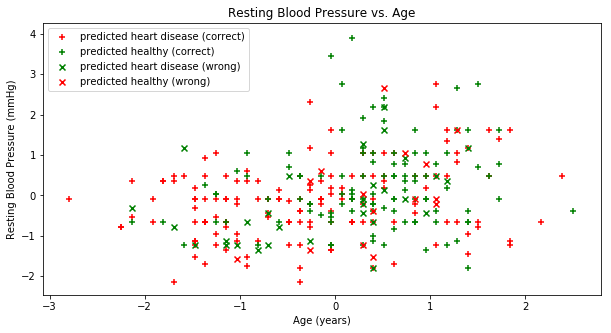

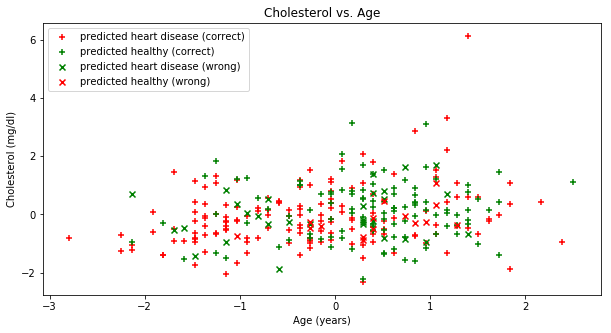

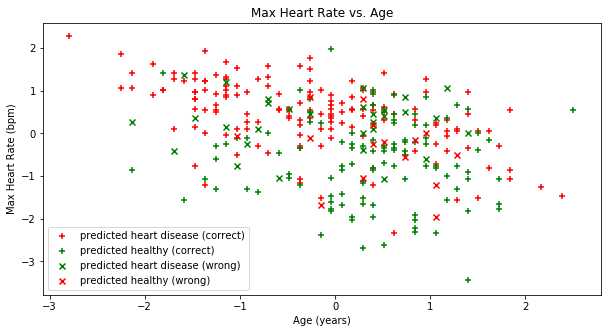

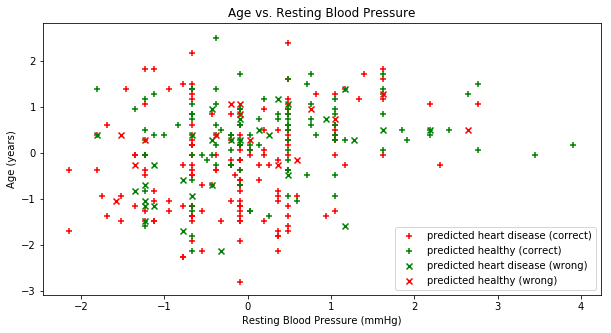

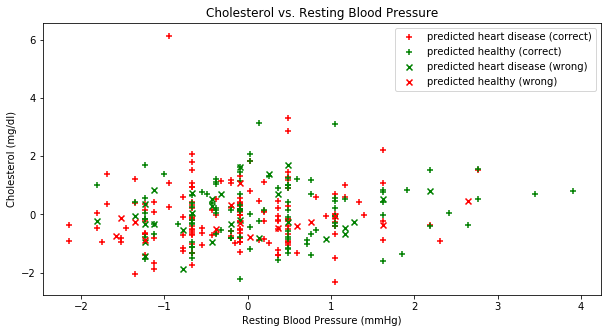

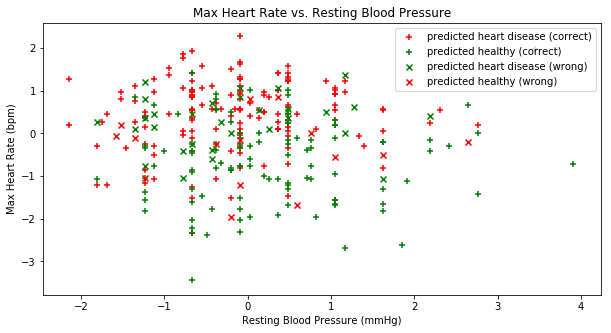

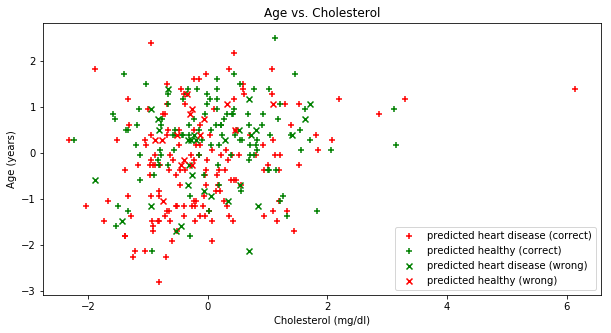

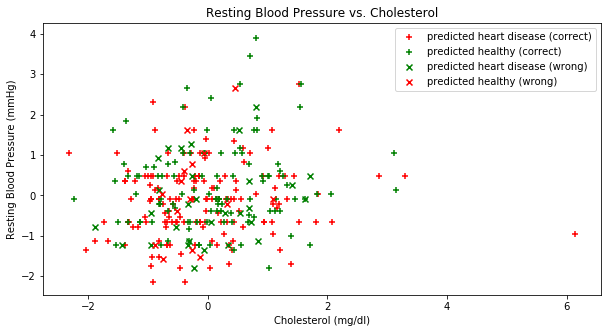

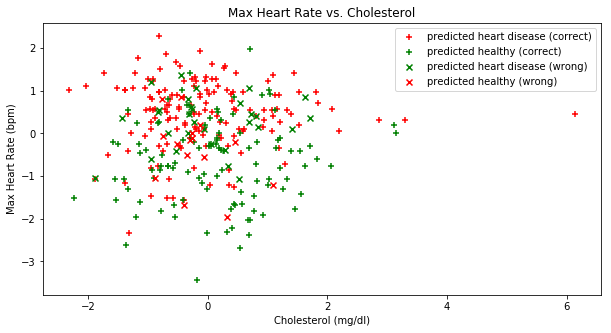

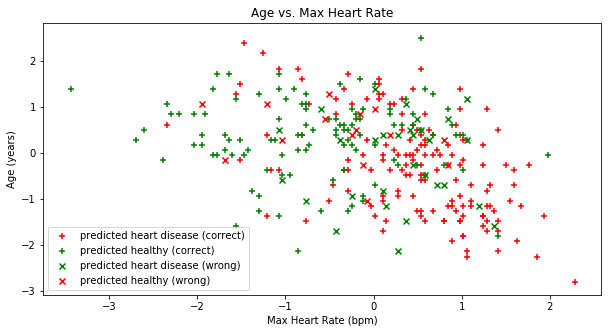

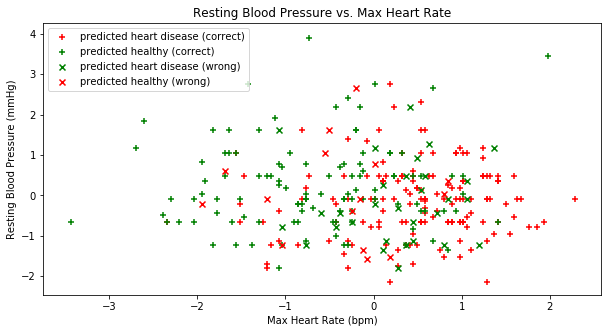

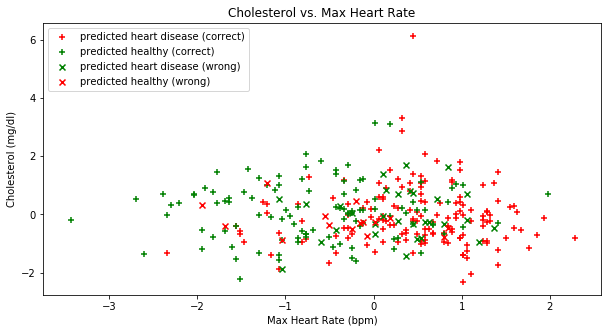

In [14]:
report_results((all_xs, all_ys, all_pred_ys))